In [398]:
# Importing

# modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime

# functions
from implementations import *
from helpers import *

#data
(labels, data, ids) = load_csv_data("data/train.csv")  # load data

In [399]:
# Function that returns tuple (data_processed and new_labels)

def process_data(data, labels, sample_filtering=True, feature_filtering=True):
    # Preparing data

    # set values of -999 to NaN. 
    # Then calculate the means of the features. 
    # Replace NaN values with new values.

    data_process = np.array(data[:10000,:])
    labels_select = np.array(labels[:10000])
    lab = []
    for entry in labels_select:
        if int(entry) == 1:
            lab.append(1)
        else:
            lab.append(0)
    lab = np.array(lab)
    data_process[data_process == -999] = np.nan

    # Filtering weak features and samples

    # retrieve percentage for each feature 
    # - how many nan's are there?
    
    if feature_filtering:
        nan_count = []
        for c in data_process.T:
            count = 0
            for e in c:
                if np.isnan(e):
                    count += 1
            pcent = count / data_process.shape[0]
            nan_count.append(pcent)

        # filter out features which have nan values of 50%

        data_set_filtered = []
        for idx, entry in enumerate(nan_count):
            if entry < 0.6:
                #append the column of the original dataset that is good
                data_set_filtered.append(data_process.T[idx]) 
        #save that shit as an np array
        data_set_filtered = np.array(data_set_filtered).T #save that shit as an np array
        
    if sample_filtering:
        nan_count_2 = []
        data_set_filtered_2 = [] # dataset filtered for columns and samples
        y = [] # array that gets rid of entries that are no longer corresponding in the dataframe
        for sample in data_set_filtered:
            count = 0
            for col in sample:
                if np.isnan(col):
                    count += 1
            pcent = count / data_set_filtered.shape[1]
            nan_count_2.append(pcent)

        for idx, entry in enumerate(nan_count_2):
            if entry < 0.15:
                y.append(lab[idx])
                data_set_filtered_2.append(data_set_filtered[idx])
        data_set_filtered_2 = np.array(data_set_filtered_2) # turn dat shit into an array
        y = np.array(y) # also this one gotta be an array


    # print new dimensions of the dataframe after filtering

    print('The original dimensions of the training data set was {0} samples'
          ' and {1} columns. After feature and sample filtering, there are'
          ' {2} samples and {3} columns'.format(data_process.shape[0],
                                                data_process.shape[1],
                                                data_set_filtered_2.shape[0],
                                                data_set_filtered_2.shape[1]))

    # Getting Rid of NAN and Replacing with Mean

    # variable reassigned
    data_nan = data_set_filtered_2.copy() 
    # create list with average values of columns, excluding nans
    column_means = [] 
    for column in data_nan.T:
        column_means.append(np.nanmean(column))
    # variable containing locations of nan in data frame
    inds = np.where(np.isnan(data_nan)) 
    # reassign locations of nan to the column means
    data_nan[inds] = np.take(column_means, inds[1])
    return (data_nan, y)

def standardize(data):
     # standardize and normalize the features
    for idx, column in enumerate(data.T):
        mean = np.mean(column)
        variance = np.std(column)
        for entry, value in enumerate(column):
            data[entry, idx] = (value - mean)/variance
    return data

(new_data, new_labels) = process_data(data, labels)
data_std = standardize(new_data)

# Shuffle data and create training and testing sections
test_ratio_ = 0.3
X_train, y_train, X_test, y_test = test_train(data_std, new_labels, test_ratio = test_ratio_)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
print('Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values' +
      ' are split for testing and training sets with the test_ratio of {}'.format(test_ratio_))

The original dimensions of the training data set was 10000 samples and 30 columns. After feature and sample filtering, there are 8976 samples and 23 columns
Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values are split for testing and training sets with the test_ratio of 0.3


In [400]:
# Lets do some regularized Logistic Regression!

def reg_logreg(y, tx, initial_w, max_iters = 10000, gamma = 0.01, 
               lam = 0.1, method = "sgd", batch_size = 250, 
               writing = False, accuracy_scores = True):
    
    def reg_logreg_loss(y, tx, w, lam):
        loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))) + 0.5 * lam * np.linalg.norm(w)) ** 2
        return loss

    ws = np.zeros([max_iters + 1, tx.shape[1]])
    ws[0] = initial_w 
    losses = []
    percents = []
    w = initial_w
    
    if method == "gd":
        for i in range(max_iters):
            h = sigmoid(np.dot(tx, w))
            grad = np.dot(tx.T, (h - y)) / y.shape[0] + lam * np.linalg.norm(w) / y.shape[0]
            w -= gamma * grad
            ws[i+1] = w
            losses.append(reg_logreg_loss(y, tx, w, lam))
            # print(compute_accuracy_logistic_regression(y, tx, w, threshold = 0.5))
            if accuracy_scores:
                percents.append(compute_accuracy_logistic_regression(y, tx, w, threshold = 0.5))
            if writing:
                if i % 500 == 0:
                    print("iteration: {iter} | loss : {l}".format(
                        iter = i, l=losses[-1] ))
                    

    if method == "sgd":
        for i in range(max_iters):   
            for mini_y, mini_X in batch_iter(y, tx, batch_size):                
                h = sigmoid(np.dot(mini_X, w))
                grad = np.dot(mini_X.T, (h - mini_y)) / mini_y.shape[0] + lam * np.linalg.norm(w) / y.shape[0]
                w -= gamma * grad
                ws[i+1] = w
                losses.append(reg_logreg_loss(mini_y, mini_x, w, lam))
                if accuracy_scores:
                    percents.append(compute_accuracy_logistic_regression(y, tx, w, threshold = 0.5))
            if writing:
                if i % 500 == 0:
                    print("iteration: {iter} | loss : {l}".format(
                        iter = i, l=losses[-1] ))

    return losses, ws, percents


In [404]:
loss, ws, p = reg_logreg(y_train, X_train, 
                         np.random.randn(X_train.shape[1]), method = 'gd', 
                         gamma = 0.05, lam = 0, max_iters= 10000, 
                         accuracy_scores = True)

# for every ws, compute an accuracy and store the result in percent_test
percent_test = []
for value in ws:
    acc = compute_accuracy_logistic_regression(y_test, X_test, value, threshold = 0.5)
    percent_test.append(acc)

    
print(loss[0],loss[-1])

4.638455923490999 0.35085213964649364


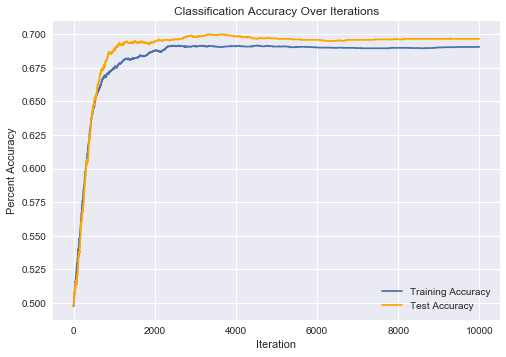

In [405]:
# print(np.array(p))
plt.style.use('seaborn')
plt.plot(p)
plt.plot(percent_test, c='orange')
plt.title('Classification Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Percent Accuracy')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.show()